# Augmentation

Trying `Batchnorm`, `Layernorm`, vs. `MyNorm`. In this version, `MyNorm` does not use momentum like `Batchnorm`. In `14_augment-Copy2`, `MyNorm` uses momentum. 

In [1]:
import torch,random
import fastcore.all as fc

from torch import nn
from torch.nn import init

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.xtras import *

In [3]:
import pickle,gzip,math,os,time,shutil
import matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,optim
from torch.utils.data import DataLoader,default_collate
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from fastcore.test import test_close
from torch import distributions

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray_r'

import logging
logging.disable(logging.WARNING)

set_seed(42)

if fc.defaults.cpus>8: fc.defaults.cpus=8

In [3]:
class LayerNorm(nn.Module):
    def __init__(self, dummy, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.mult = nn.Parameter(tensor(1.))
        self.add  = nn.Parameter(tensor(0.))

    def forward(self, x):
        m = x.mean((1,2,3), keepdim=True)
        v = x.var ((1,2,3), keepdim=True)
        x = (x-m) / ((v+self.eps).sqrt())
        return x*self.mult + self.add

In [4]:
bs = 1024

dls = get_dls(bs=bs, num_workers=8)

In [5]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)

In [6]:
set_seed(42)
lr,epochs = 6e-2,5

## Going wider

In [7]:
def get_model(act=nn.ReLU, nfs=(16,32,64,128,256,512), norm=nn.BatchNorm2d):
    layers = [ResBlock(1, 16, ks=5, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [nn.Flatten(), nn.Linear(nfs[-1], 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers)

In [8]:
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

accuracy,loss,epoch,train,time
0.825,0.704,0,True,00:21
0.845,0.596,0,False,00:00
0.896,0.386,1,True,00:21
0.899,0.328,1,False,00:01
0.921,0.267,2,True,00:22
0.903,0.297,2,False,00:02
0.941,0.196,3,True,00:22
0.926,0.235,3,False,00:02
0.962,0.138,4,True,00:23
0.931,0.223,4,False,00:02


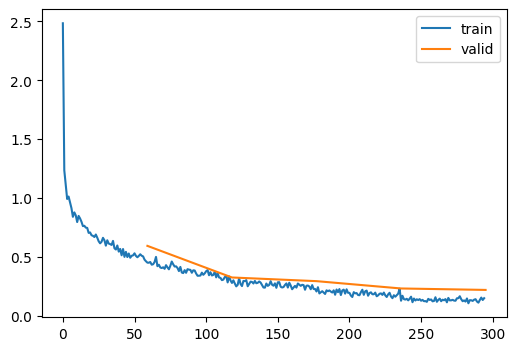

Total Time Spent: 01:59


In [9]:
learn.fit(epochs)

accuracy,loss,epoch,train,time
0.814,0.732,0,True,00:18
0.862,0.495,0,False,00:03
0.887,0.405,1,True,00:17
0.890,0.359,1,False,00:03
0.914,0.284,2,True,00:20
0.908,0.286,2,False,00:02
0.937,0.208,3,True,00:20
0.922,0.249,3,False,00:02
0.958,0.152,4,True,00:18
0.925,0.245,4,False,00:03


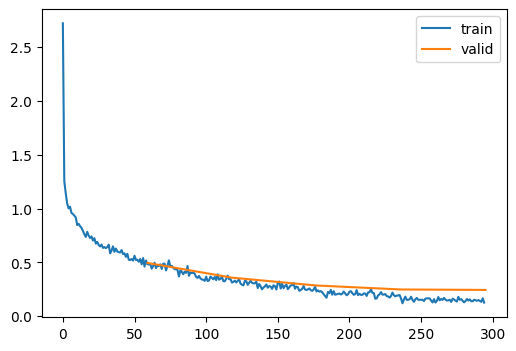

Total Time Spent: 03:50


In [10]:
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
model = get_model(act_gr, norm=LayerNorm).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

accuracy,loss,epoch,train,time
0.821,0.715,0,True,00:20
0.866,0.462,0,False,00:02
0.895,0.386,1,True,00:23
0.900,0.326,1,False,00:03
0.920,0.269,2,True,00:21
0.916,0.266,2,False,00:03
0.942,0.196,3,True,00:18
0.928,0.233,3,False,00:02
0.963,0.138,4,True,00:19
0.932,0.224,4,False,00:03


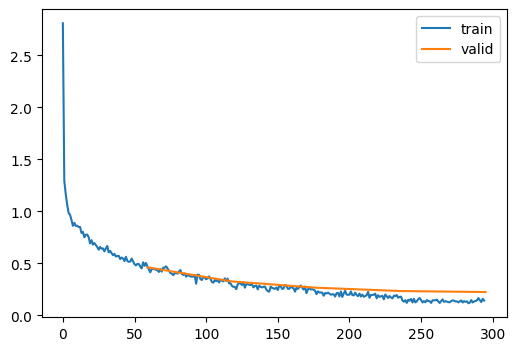

Total Time Spent: 05:49


In [11]:
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
model = get_model(act_gr, norm=MyNorm).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

In [11]:
class MyNorm(nn.Module):
    """Simple like layernorm but taking mean/std like batch norm.
    With momentum."""
    def __init__(self, dummy, eps = 1e-4):
        super().__init__()
        self.eps = eps
        self.mult = nn.Parameter(tensor(1.))
        self.add = nn.Parameter(tensor(0.))
    
    def forward(self, x):
        m = x.mean((0,2,3), keepdim=True)
        v = x.var ((0,2,3), keepdim=True)
        x = (x-m) / ((v+self.eps).sqrt())
        return x*self.mult + self.add

accuracy,loss,epoch,train,time
0.830,0.698,0,True,00:19
0.876,0.462,0,False,00:03
0.897,0.384,1,True,00:17
0.887,0.355,1,False,00:03
0.918,0.271,2,True,00:17
0.916,0.265,2,False,00:03
0.942,0.197,3,True,00:16
0.921,0.243,3,False,00:03
0.963,0.141,4,True,00:16
0.930,0.230,4,False,00:03


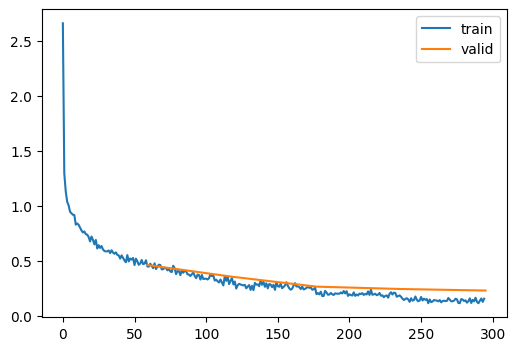

Total Time Spent: 03:53


In [12]:
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
model = get_model(act_gr, norm=MyNorm).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

accuracy,loss,epoch,train,time
0.835,0.677,0,True,00:19
0.873,0.462,0,False,00:03
0.898,0.381,1,True,00:17
0.885,0.365,1,False,00:03
0.918,0.272,2,True,00:16
0.909,0.281,2,False,00:03
0.942,0.196,3,True,00:16
0.922,0.245,3,False,00:03
0.964,0.137,4,True,00:16
0.931,0.230,4,False,00:03


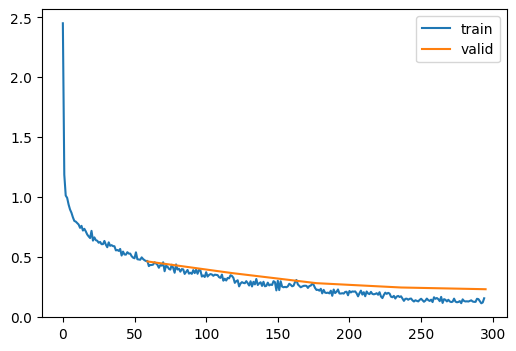

Total Time Spent: 05:37


In [13]:
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
model = get_model(act_gr, norm=MyNorm).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

### Pooling

In [12]:
class GlobalAvgPool(nn.Module):
    def forward(self, x): return x.mean((-2,-1))

In [13]:
def get_model2(act=nn.ReLU, nfs=(16,32,64,128,256), norm=nn.BatchNorm2d):
    layers = [ResBlock(1, 16, ks=5, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [ResBlock(256, 512, act=act, norm=norm), GlobalAvgPool()]
    layers += [nn.Linear(512, 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers)

In [14]:
 
def _flops(x, h, w):
    if x.dim()<3: return x.numel()
    if x.dim()==4: return x.numel()*h*w

@fc.patch
def summary(self:Learner):
    res = '|Module|Input|Output|Num params|MFLOPS|\n|--|--|--|--|--|\n'
    totp,totf = 0,0
    def _f(hook, mod, inp, outp):
        nonlocal res,totp,totf
        nparms = sum(o.numel() for o in mod.parameters())
        totp += nparms
        *_,h,w = outp.shape
        flops = sum(_flops(o, h, w) for o in mod.parameters())/1e6
        totf += flops
        res += f'|{type(mod).__name__}|{tuple(inp[0].shape)}|{tuple(outp.shape)}|{nparms}|{flops:.1f}|\n'
    with Hooks(self.model, _f) as hooks: self.fit(1, lr=1, cbs=SingleBatchCB())
    print(f"Tot params: {totp}; MFLOPS: {totf:.1f}")
    if fc.IN_NOTEBOOK:
        from IPython.display import Markdown
        return Markdown(res)
    else: print(res)

In [15]:
TrainLearner(get_model2(), dls, F.cross_entropy, lr=lr, cbs=[DeviceCB()]).summary()

Tot params: 4907588; MFLOPS: 33.0


|Module|Input|Output|Num params|MFLOPS|
|--|--|--|--|--|
|ResBlock|(1024, 1, 28, 28)|(1024, 16, 28, 28)|6928|5.3|
|ResBlock|(1024, 16, 28, 28)|(1024, 32, 14, 14)|14560|2.8|
|ResBlock|(1024, 32, 14, 14)|(1024, 64, 7, 7)|57792|2.8|
|ResBlock|(1024, 64, 7, 7)|(1024, 128, 4, 4)|230272|3.7|
|ResBlock|(1024, 128, 4, 4)|(1024, 256, 2, 2)|919296|3.7|
|ResBlock|(1024, 256, 2, 2)|(1024, 512, 2, 2)|3673600|14.7|
|GlobalAvgPool|(1024, 512, 2, 2)|(1024, 512)|0|0.0|
|Linear|(1024, 512)|(1024, 10)|5120|0.0|
|BatchNorm1d|(1024, 10)|(1024, 10)|20|0.0|


accuracy,loss,epoch,train,time
0.822,0.715,0,True,00:17
0.864,0.507,0,False,00:02
0.898,0.382,1,True,00:15
0.882,0.407,1,False,00:03
0.920,0.271,2,True,00:15
0.908,0.285,2,False,00:03
0.941,0.198,3,True,00:15
0.923,0.249,3,False,00:02
0.962,0.142,4,True,00:15
0.929,0.225,4,False,00:02


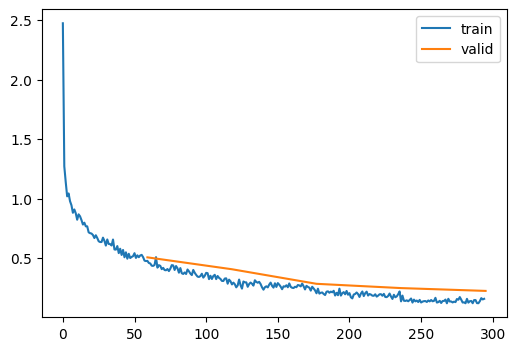

Total Time Spent: 07:23


In [16]:
set_seed(42)
model = get_model2(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

accuracy,loss,epoch,train,time
0.812,0.739,0,True,00:20
0.848,0.520,0,False,00:03
0.893,0.391,1,True,00:18
0.881,0.371,1,False,00:02
0.917,0.276,2,True,00:16
0.907,0.291,2,False,00:03
0.938,0.204,3,True,00:16
0.922,0.252,3,False,00:03
0.958,0.150,4,True,00:16
0.924,0.238,4,False,00:03


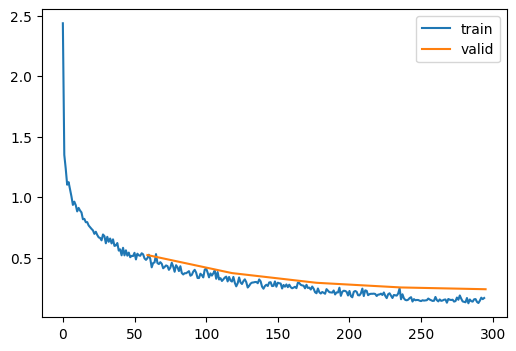

Total Time Spent: 09:08


In [17]:
set_seed(42)
model = get_model2(act_gr, norm=LayerNorm).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

accuracy,loss,epoch,train,time
0.811,0.739,0,True,00:19
0.870,0.454,0,False,00:02
0.897,0.383,1,True,00:20
0.902,0.323,1,False,00:03
0.921,0.265,2,True,00:16
0.914,0.276,2,False,00:03
0.943,0.194,3,True,00:16
0.927,0.239,3,False,00:03
0.964,0.135,4,True,00:16
0.928,0.229,4,False,00:03


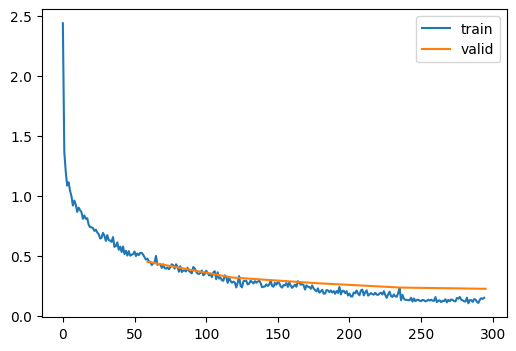

Total Time Spent: 10:53


In [18]:
set_seed(42)
model = get_model2(act_gr, norm=MyNorm).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

In [19]:
def get_model3(act=nn.ReLU, nfs=(16,32,64,128,256), norm=nn.BatchNorm2d):
    layers = [ResBlock(1, 16, ks=5, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [GlobalAvgPool(), nn.Linear(256, 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers)

In [20]:
TrainLearner(get_model3(), dls, F.cross_entropy, lr=lr, cbs=[DeviceCB()]).summary()

Tot params: 1231428; MFLOPS: 18.3


|Module|Input|Output|Num params|MFLOPS|
|--|--|--|--|--|
|ResBlock|(1024, 1, 28, 28)|(1024, 16, 28, 28)|6928|5.3|
|ResBlock|(1024, 16, 28, 28)|(1024, 32, 14, 14)|14560|2.8|
|ResBlock|(1024, 32, 14, 14)|(1024, 64, 7, 7)|57792|2.8|
|ResBlock|(1024, 64, 7, 7)|(1024, 128, 4, 4)|230272|3.7|
|ResBlock|(1024, 128, 4, 4)|(1024, 256, 2, 2)|919296|3.7|
|GlobalAvgPool|(1024, 256, 2, 2)|(1024, 256)|0|0.0|
|Linear|(1024, 256)|(1024, 10)|2560|0.0|
|BatchNorm1d|(1024, 10)|(1024, 10)|20|0.0|


In [21]:
[o.shape for o in get_model3()[0].parameters()]

[torch.Size([16, 1, 5, 5]),
 torch.Size([16]),
 torch.Size([16]),
 torch.Size([16]),
 torch.Size([16, 16, 5, 5]),
 torch.Size([16]),
 torch.Size([16]),
 torch.Size([16]),
 torch.Size([16, 1, 1, 1]),
 torch.Size([16])]

accuracy,loss,epoch,train,time
0.810,0.759,0,True,00:16
0.873,0.461,0,False,00:03
0.897,0.395,1,True,00:15
0.900,0.329,1,False,00:03
0.921,0.274,2,True,00:15
0.901,0.309,2,False,00:03
0.940,0.206,3,True,00:14
0.927,0.244,3,False,00:03
0.961,0.149,4,True,00:14
0.928,0.230,4,False,00:03


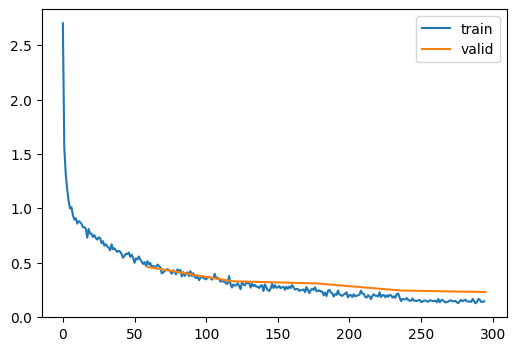

Total Time Spent: 12:26


In [22]:
set_seed(42)
model = get_model3(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

accuracy,loss,epoch,train,time
0.804,0.774,0,True,00:19
0.860,0.493,0,False,00:03
0.892,0.400,1,True,00:18
0.897,0.350,1,False,00:03
0.916,0.276,2,True,00:15
0.902,0.305,2,False,00:03
0.939,0.205,3,True,00:15
0.922,0.248,3,False,00:03
0.961,0.146,4,True,00:15
0.929,0.237,4,False,00:03


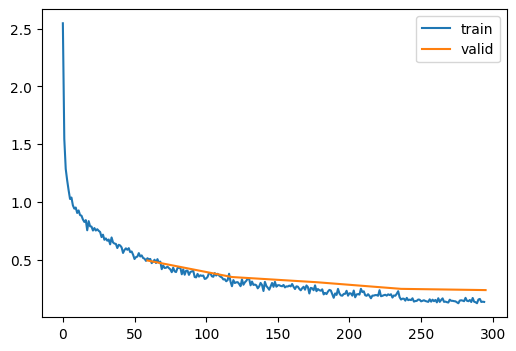

Total Time Spent: 14:06


In [23]:
set_seed(42)
model = get_model3(act_gr, norm=LayerNorm).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

accuracy,loss,epoch,train,time
0.805,0.773,0,True,00:17
0.869,0.484,0,False,00:03
0.896,0.400,1,True,00:19
0.900,0.333,1,False,00:03
0.919,0.276,2,True,00:15
0.905,0.292,2,False,00:03
0.940,0.204,3,True,00:15
0.924,0.243,3,False,00:02
0.961,0.148,4,True,00:15
0.929,0.233,4,False,00:03


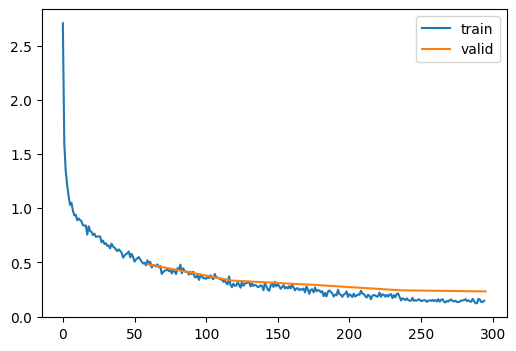

Total Time Spent: 15:45


In [24]:
set_seed(42)
model = get_model3(act_gr, norm=MyNorm).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

In [25]:
def get_model4(act=nn.ReLU, nfs=(16,32,64,128,256), norm=nn.BatchNorm2d):
    layers = [conv(1, 16, ks=5, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [GlobalAvgPool(), nn.Linear(256, 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers)

In [26]:
[o.shape for o in get_model4()[0].parameters()]

[torch.Size([16, 1, 5, 5]),
 torch.Size([16]),
 torch.Size([16]),
 torch.Size([16])]

In [27]:
TrainLearner(get_model4(), dls, F.cross_entropy, lr=lr, cbs=[DeviceCB()]).summary()

Tot params: 1224948; MFLOPS: 13.3


|Module|Input|Output|Num params|MFLOPS|
|--|--|--|--|--|
|Sequential|(1024, 1, 28, 28)|(1024, 16, 28, 28)|448|0.3|
|ResBlock|(1024, 16, 28, 28)|(1024, 32, 14, 14)|14560|2.8|
|ResBlock|(1024, 32, 14, 14)|(1024, 64, 7, 7)|57792|2.8|
|ResBlock|(1024, 64, 7, 7)|(1024, 128, 4, 4)|230272|3.7|
|ResBlock|(1024, 128, 4, 4)|(1024, 256, 2, 2)|919296|3.7|
|GlobalAvgPool|(1024, 256, 2, 2)|(1024, 256)|0|0.0|
|Linear|(1024, 256)|(1024, 10)|2560|0.0|
|BatchNorm1d|(1024, 10)|(1024, 10)|20|0.0|


accuracy,loss,epoch,train,time
0.803,0.782,0,True,00:13
0.872,0.466,0,False,00:03
0.897,0.392,1,True,00:13
0.886,0.368,1,False,00:02
0.918,0.277,2,True,00:13
0.893,0.333,2,False,00:03
0.940,0.203,3,True,00:13
0.925,0.237,3,False,00:03
0.962,0.148,4,True,00:13
0.926,0.235,4,False,00:03


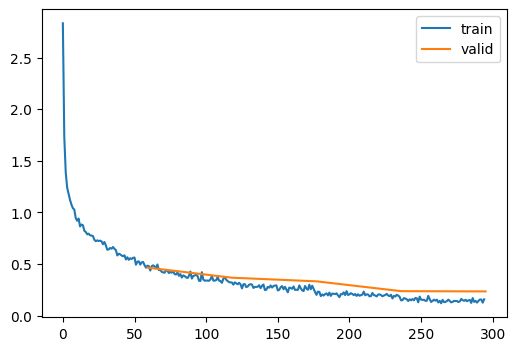

Total Time Spent: 17:08


In [28]:
set_seed(42)
model = get_model4(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

accuracy,loss,epoch,train,time
0.803,0.777,0,True,00:15
0.844,0.529,0,False,00:02
0.891,0.400,1,True,00:13
0.877,0.396,1,False,00:02
0.916,0.281,2,True,00:13
0.903,0.302,2,False,00:03
0.940,0.204,3,True,00:13
0.918,0.254,3,False,00:02
0.961,0.147,4,True,00:13
0.922,0.246,4,False,00:03


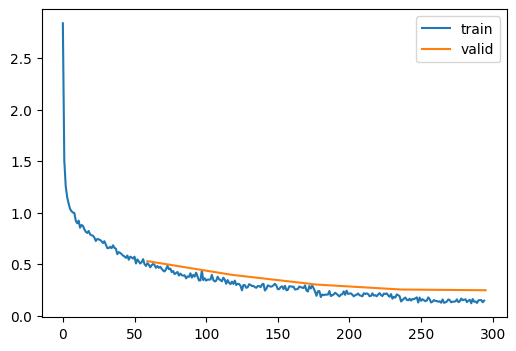

Total Time Spent: 18:33


In [29]:
set_seed(42)
model = get_model4(act_gr, norm=LayerNorm).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

accuracy,loss,epoch,train,time
0.803,0.785,0,True,00:14
0.864,0.504,0,False,00:03
0.896,0.393,1,True,00:13
0.900,0.344,1,False,00:03
0.918,0.277,2,True,00:13
0.913,0.287,2,False,00:03
0.942,0.200,3,True,00:13
0.924,0.242,3,False,00:02
0.963,0.145,4,True,00:14
0.926,0.238,4,False,00:02


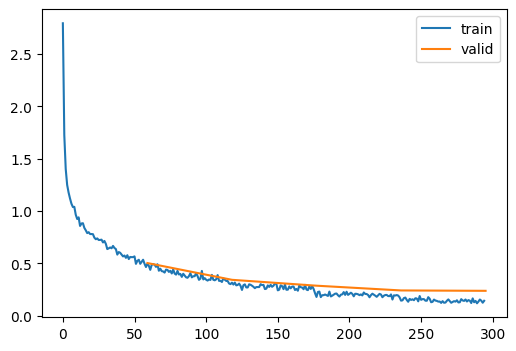

Total Time Spent: 19:58


In [30]:
set_seed(42)
model = get_model4(act_gr, norm=MyNorm).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

## Data augmentation

After 20 epochs without augmentation:

```
{'accuracy': '0.999', 'loss': '0.012', 'epoch': 19, 'train': True}
{'accuracy': '0.924', 'loss': '0.284', 'epoch': 19, 'train': False}
```

With batchnorm, weight decay doesn't really regularize.

In [31]:
from torchvision import transforms

In [32]:
def tfm_batch(b, tfm_x=fc.noop, tfm_y = fc.noop): return tfm_x(b[0]),tfm_y(b[1])

tfms = nn.Sequential(transforms.RandomCrop(28, padding=4),
                     transforms.RandomHorizontalFlip())

augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)
model = get_model()
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=[SingleBatchCB(), augcb])

In [33]:
learn.fit(1)

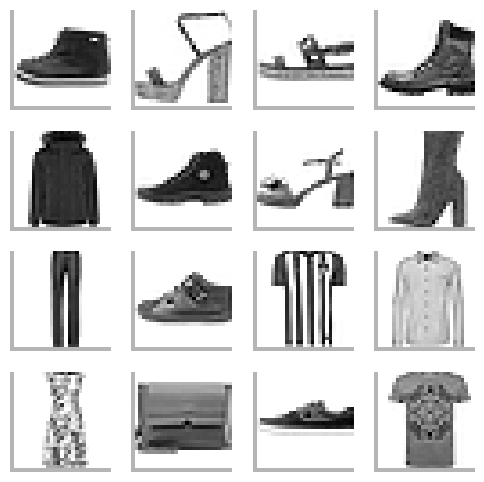

In [34]:
xb,yb = learn.batch
show_images(xb[:16], imsize=1.5)

In [35]:
@fc.patch
@fc.delegates(show_images)
def show_image_batch(self:Learner, max_n=9, cbs=None, **kwargs):
    self.fit(1, cbs=[SingleBatchCB()]+fc.L(cbs))
    show_images(self.batch[0][:max_n], **kwargs)

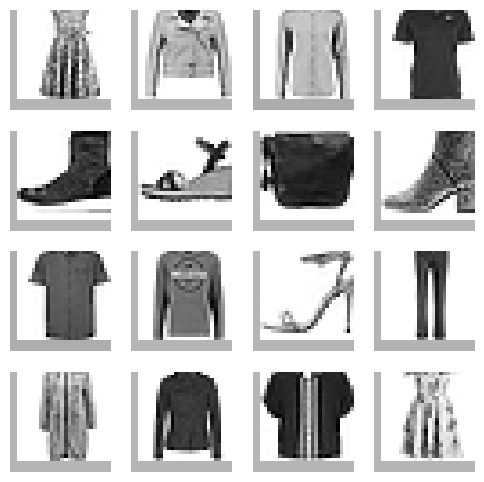

In [36]:
learn.show_image_batch(max_n=16, imsize=(1.5))

In [37]:
tfms = nn.Sequential(transforms.RandomCrop(28, padding=1),
                     transforms.RandomHorizontalFlip())
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

accuracy,loss,epoch,train,time
0.763,0.880,0,True,00:16
0.827,0.602,0,False,00:03
0.858,0.596,1,True,00:16
0.866,0.480,1,False,00:03
0.875,0.477,2,True,00:15
0.823,0.577,2,False,00:03
0.886,0.396,3,True,00:15
0.891,0.337,3,False,00:03
0.896,0.333,4,True,00:15
0.874,0.404,4,False,00:03


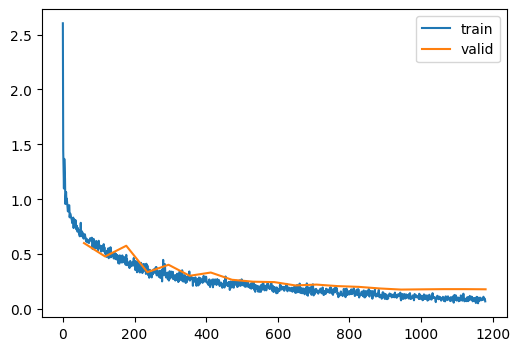

Total Time Spent: 26:13


In [38]:
set_seed(42)
epochs = 20
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), augcb]
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

accuracy,loss,epoch,train,time
0.753,0.920,0,True,00:17
0.825,0.632,0,False,00:03
0.843,0.629,1,True,00:17
0.814,0.617,1,False,00:03
0.861,0.511,2,True,00:16
0.836,0.519,2,False,00:03
0.876,0.422,3,True,00:16
0.882,0.376,3,False,00:03
0.890,0.352,4,True,00:16
0.890,0.324,4,False,00:03


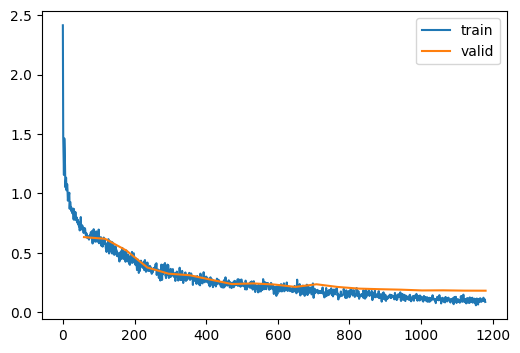

Total Time Spent: 32:43


In [39]:
set_seed(42)
epochs = 20
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), augcb]
model = get_model(act_gr, norm=LayerNorm).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

accuracy,loss,epoch,train,time
0.756,0.902,0,True,00:17
0.834,0.618,0,False,00:03
0.856,0.601,1,True,00:17
0.874,0.487,1,False,00:03
0.874,0.483,2,True,00:16
0.874,0.423,2,False,00:03
0.885,0.396,3,True,00:16
0.891,0.355,3,False,00:03
0.896,0.337,4,True,00:16
0.902,0.303,4,False,00:03


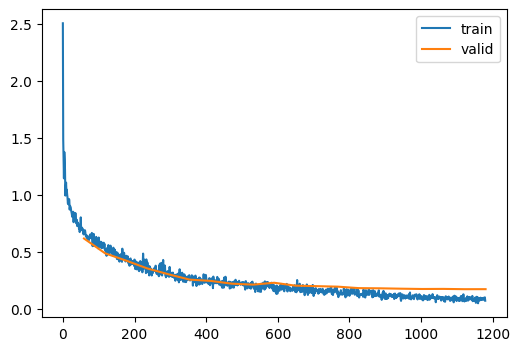

Total Time Spent: 39:18


In [40]:
set_seed(42)
epochs = 20
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), augcb]
model = get_model(act_gr, norm=MyNorm).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

A custom collation function could let you do per-item transformations.

## Random erase

In [49]:
xb,_ = next(iter(dls.train))
xbt = xb[:16]

In [50]:
xm,xs = xbt.mean(),xbt.std()

In [51]:
xbt.min(), xbt.max()

(tensor(-0.83), tensor(2.03))

In [52]:
pct = 0.2

In [53]:
szx = int(pct*xbt.shape[-2])
szy = int(pct*xbt.shape[-1])
stx = int(random.random()*(1-pct)*xbt.shape[-2])
sty = int(random.random()*(1-pct)*xbt.shape[-1])
stx,sty,szx,szy

(14, 0, 5, 5)

In [54]:
init.normal_(xbt[:,:,stx:stx+szx,sty:sty+szy], mean=xm, std=xs);

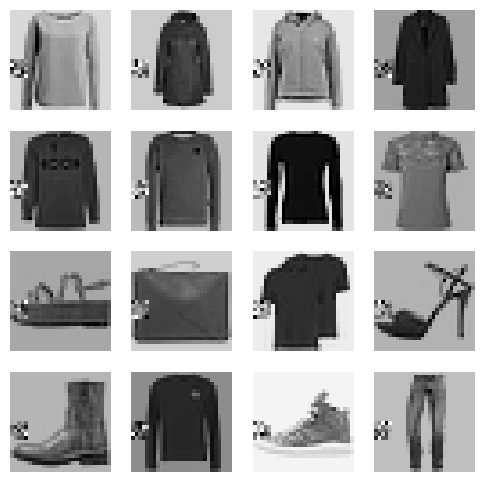

In [55]:
show_images(xbt, imsize=1.5)

In [56]:
xbt.min(), xbt.max()

(tensor(-3.39), tensor(2.53))

In [57]:
def _rand_erase1(x, pct, xm, xs, mn, mx):
    szx = int(pct*x.shape[-2])
    szy = int(pct*x.shape[-1])
    stx = int(random.random()*(1-pct)*x.shape[-2])
    sty = int(random.random()*(1-pct)*x.shape[-1])
    init.normal_(x[:,:,stx:stx+szx,sty:sty+szy], mean=xm, std=xs)
    x.clamp_(mn, mx)

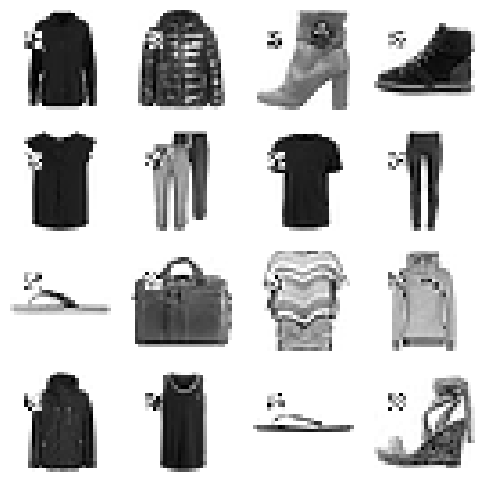

In [58]:
xb,_ = next(iter(dls.train))
xbt = xb[:16]
_rand_erase1(xbt, 0.2, xbt.mean(), xbt.std(), xbt.min(), xbt.max())
show_images(xbt, imsize=1.5)

In [59]:
xbt.mean(),xbt.std(),xbt.min(), xbt.max()

(tensor(0.06), tensor(1.04), tensor(-0.83), tensor(2.03))

In [60]:
def rand_erase(x, pct=0.2, max_num = 4):
    xm,xs,mn,mx = x.mean(),x.std(),x.min(),x.max()
    num = random.randint(0, max_num)
    for i in range(num): _rand_erase1(x, pct, xm, xs, mn, mx)
#     print(num)
    return x

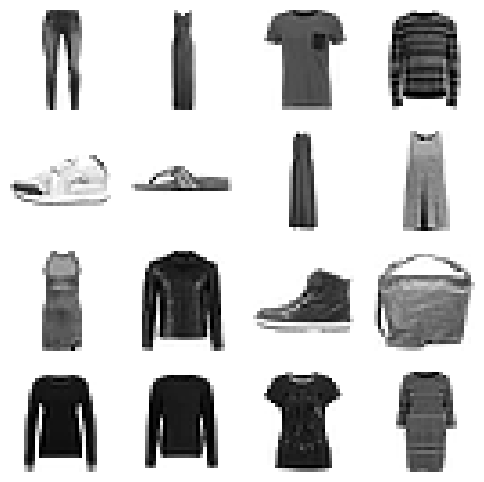

In [61]:
xb,_ = next(iter(dls.train))
xbt = xb[:16]
rand_erase(xbt, 0.2, 4)
show_images(xbt, imsize=1.5)

In [62]:
class RandErase(nn.Module):
    def __init__(self, pct=0.2, max_num=4):
        super().__init__()
        self.pct,self.max_num = pct,max_num
    def forward(self, x): return rand_erase(x, self.pct, self.max_num)

In [63]:
tfms = nn.Sequential(transforms.RandomCrop(28, padding=1),
                     transforms.RandomHorizontalFlip(),
                     RandErase())
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

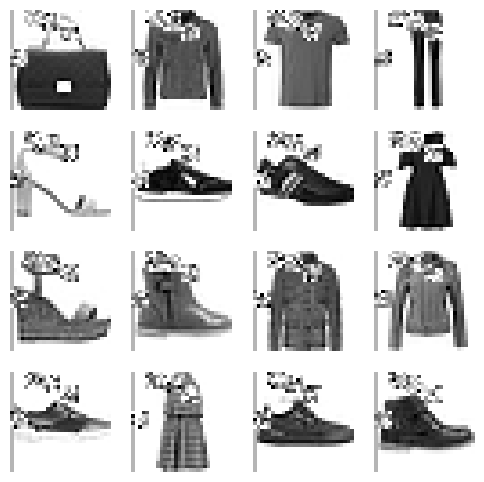

In [64]:
model = get_model()
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=[DeviceCB(), SingleBatchCB(), augcb])
learn.fit(1)
xb,yb = learn.batch
show_images(xb[:16], imsize=1.5)

accuracy,loss,epoch,train,time
0.756,0.888,0,True,00:15
0.834,0.578,0,False,00:03
0.843,0.623,1,True,00:15
0.857,0.542,1,False,00:03
0.863,0.531,2,True,00:15
0.854,0.475,2,False,00:03
0.870,0.466,3,True,00:15
0.856,0.467,3,False,00:03
0.877,0.411,4,True,00:15
0.893,0.331,4,False,00:03


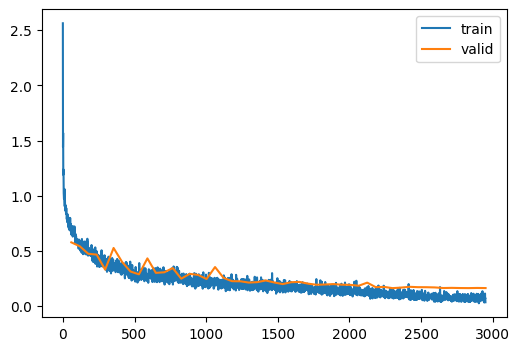

Total Time Spent: 55:09


In [65]:
epochs = 50
lr = 2e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), augcb]
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

accuracy,loss,epoch,train,time
0.725,0.971,0,True,00:17
0.799,0.693,0,False,00:03
0.815,0.691,1,True,00:16
0.821,0.597,1,False,00:03
0.833,0.601,2,True,00:16
0.842,0.516,2,False,00:03
0.845,0.527,3,True,00:16
0.817,0.545,3,False,00:03
0.854,0.471,4,True,00:16
0.841,0.470,4,False,00:03


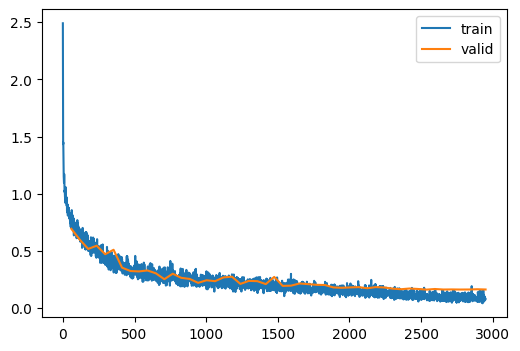

Total Time Spent: 1:11:31


In [66]:
epochs = 50
lr = 2e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), augcb]
model = get_model(act_gr, norm=LayerNorm).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

accuracy,loss,epoch,train,time
0.753,0.894,0,True,00:17
0.817,0.646,0,False,00:03
0.840,0.633,1,True,00:17
0.855,0.524,1,False,00:03
0.854,0.557,2,True,00:17
0.868,0.439,2,False,00:03
0.867,0.473,3,True,00:16
0.877,0.404,3,False,00:03
0.872,0.428,4,True,00:16
0.884,0.358,4,False,00:03


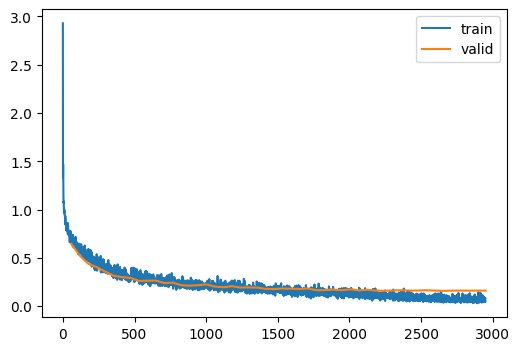

Total Time Spent: 1:27:58


In [67]:
epochs = 50
lr = 2e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), augcb]
model = get_model(act_gr, norm=MyNorm).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

## Dropout

In [86]:
p = 0.1
dist = distributions.binomial.Binomial(probs=1-p)
dist.sample((10,))

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [87]:
class Dropout(nn.Module):
    def __init__(self, p=0.1):
        super().__init__()
        self.p = p

    def forward(self, x):
        if not self.training: return x
        dist = distributions.binomial.Binomial(tensor(1.0).to(x.device), probs=1-self.p)
        return x * dist.sample(x.size()) * 1/(1-self.p)

In [88]:
def get_dropmodel(act=nn.ReLU, nfs=(16,32,64,128,256,512), norm=nn.BatchNorm2d, drop=0.0):
    layers = [ResBlock(1, 16, ks=5, stride=1, act=act, norm=norm), nn.Dropout2d(drop)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [nn.Flatten(), Dropout(drop), nn.Linear(nfs[-1], 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers)

In [89]:
set_seed(42)
epochs=5
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
model = get_dropmodel(act_gr, norm=nn.BatchNorm2d, drop=0.1).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

accuracy,loss,epoch,train,time
0.809,0.745,0,True,00:16
0.854,0.483,0,False,00:03
0.894,0.393,1,True,00:15
0.899,0.325,1,False,00:03
0.919,0.276,2,True,00:15
0.912,0.275,2,False,00:03
0.937,0.208,3,True,00:15
0.925,0.234,3,False,00:03
0.958,0.154,4,True,00:15
0.930,0.225,4,False,00:03


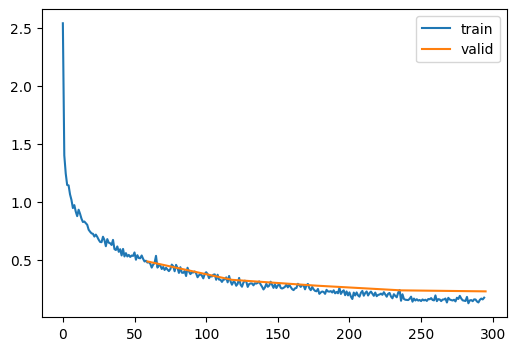

Total Time Spent: 1:29:33


In [90]:
learn.fit(epochs)

accuracy,loss,epoch,train,time
0.803,0.751,0,True,00:17
0.852,0.497,0,False,00:03
0.889,0.399,1,True,00:16
0.885,0.353,1,False,00:03
0.915,0.282,2,True,00:17
0.910,0.284,2,False,00:03
0.934,0.216,3,True,00:16
0.924,0.242,3,False,00:03
0.954,0.162,4,True,00:16
0.926,0.234,4,False,00:03


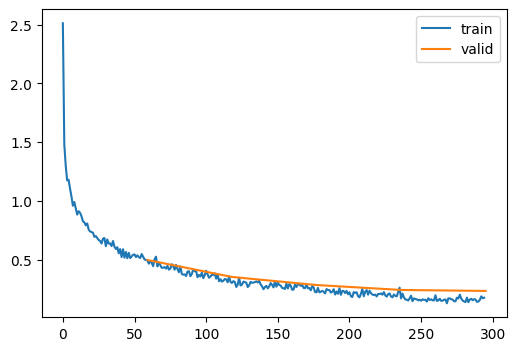

Total Time Spent: 1:31:14


In [91]:
set_seed(42)
epochs=5
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
model = get_dropmodel(act_gr, norm=LayerNorm, drop=0.1).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

accuracy,loss,epoch,train,time
0.803,0.758,0,True,00:17
0.875,0.436,0,False,00:03
0.895,0.387,1,True,00:16
0.899,0.321,1,False,00:03
0.918,0.273,2,True,00:16
0.913,0.276,2,False,00:03
0.938,0.204,3,True,00:17
0.927,0.232,3,False,00:03
0.959,0.148,4,True,00:17
0.930,0.224,4,False,00:03


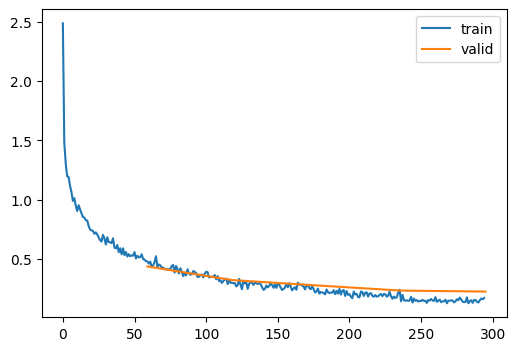

Total Time Spent: 1:32:55


In [92]:
set_seed(42)
epochs=5
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
model = get_dropmodel(act_gr, norm=MyNorm, drop=0.1).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)